In [1]:
# imports pandas library
import pandas as pd 

# imports numpy library
import numpy as np 

# imports matplotlib library for data viz
import matplotlib.pyplot as plt 

# imports seaborn for data viz
import seaborn as sns

import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Reads the dataset
df = pd.read_csv('CleanedCust.csv') 
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  amount  
0  12/1/2010 8:26       2.55       17850  United Kingdom   15.30  
1  12/1/2010 8:26       3.39       17850  United Kingdom   20.34  
2  12/1/2010 8:26       2.75       17850  United Kingdom   22.00  
3  12/1/2010 8:26       3.39       17850  United Kingdom   20.34  
4  12/1/2010 8:26       3.39       17850  United Kingdom   20.34

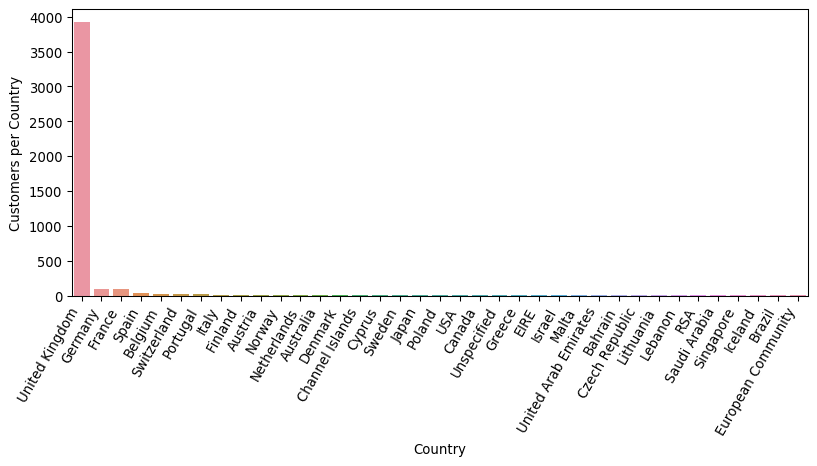

In [2]:
country_cust = pd.DataFrame(df.groupby('Country')['CustomerID'].nunique())
country_cust.columns = ['Customers per Country']
country_cust.sort_values('Customers per Country', inplace=True, ascending=False)
fig, ax = plt.subplots(figsize=(10,4),dpi=95)
ax=sns.barplot(x=country_cust.index, y=country_cust['Customers per Country'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.show()

In [3]:
#As most of the customers are in UK so we focus on UK data
uk_df = df[df['Country']=='United Kingdom']
uk_df.describe()

InvoiceNo       Quantity      UnitPrice     CustomerID  \
count  354321.00000  354321.000000  354321.000000  354321.000000   
mean   560672.52133      12.013795       2.963994   15552.486392   
std     13168.90343     189.267956      17.862655    1594.527150   
min    536365.00000       1.000000       0.001000   12346.000000   
25%    549241.00000       2.000000       1.250000   14194.000000   
50%    561900.00000       4.000000       1.950000   15522.000000   
75%    572295.00000      12.000000       3.750000   16931.000000   
max    581586.00000   80995.000000    8142.750000   18287.000000   

              amount  
count  354321.000000  
mean       20.626470  
std       326.044012  
min         0.001000  
25%         4.160000  
50%        10.200000  
75%        17.700000  
max    168469.600000

In [4]:
#For Checking the shape of the data set of UK
uk_df.shape

(354321, 9)

In [5]:
#For finding out the first and the last order dates in UK data
uk_df['InvoiceDate'].min()
uk_df['InvoiceDate'].max()

'9/9/2011 9:52'

In [6]:
#For finding out the current recency, we create today
today = datetime.datetime(2011,12,10)
today
uk_df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
uk_df.dtypes

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


InvoiceNo               int64
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
amount                float64
dtype: object

In [7]:
#Creating an RFM Customer Segmentation Table
rfm_UK = uk_df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (today - x.max()).days, 'InvoiceNo': lambda x: len(x), 'amount': lambda x: x.sum()})
rfm_UK['InvoiceDate'] = rfm_UK['InvoiceDate'].astype(int)
rfm_UK.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'amount': 'Monetary_value'}, inplace=True)

In [8]:
#RFM metric for each customer
#monetary value=Unit price * quantity = amount
rfm_UK.head()

Recency  Frequency  Monetary_value
CustomerID                                    
12346           325          1        77183.60
12747             2        103         4196.01
12748             0       4595        33719.73
12749             3        199         4090.88
12820             3         59          942.34

In [9]:
#Example interpretation
cs1=uk_df[uk_df['CustomerID']==1282]
cs1

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, amount]
Index: []

In [12]:
#Splitting the metrics into segments by creating quantiles, creating 4 groups 4 in this case
# Using quantile-based discretization function to create labels and assigning them to the percentile groups 
rl = range(4, 0, -1)
rg = pd.qcut(rfm_UK.Recency, q = 4, labels = rl)

fl = range(1, 5)
fg = pd.qcut(rfm_UK.Frequency, q = 4, labels = fl)

ml = range(1, 5)
mg = pd.qcut(rfm_UK.Monetary_value, q = 4, labels = ml)

mg.head()

CustomerID
12346    4
12747    4
12748    4
12749    4
12820    3
Name: Monetary_value, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

In [13]:
# make columns for quartiles
rfm_UK['R_Quartile'] = rg.values
rfm_UK['F_Quartile'] = fg.values
rfm_UK['M_Quartile'] = mg.values

In [14]:
# summing up the three quartile columns
rfm_UK['RFM_Segment'] = rfm_UK.apply(lambda a: str(a['R_Quartile']) + str(a['F_Quartile']) + str(a['M_Quartile']), axis = 1)
rfm_UK['RFM_Score'] = rfm_UK[['R_Quartile', 'F_Quartile', 'M_Quartile']].sum(axis = 1)
rfm_UK.head()

Recency  Frequency  Monetary_value R_Quartile F_Quartile  \
CustomerID                                                             
12346           325          1        77183.60          1          1   
12747             2        103         4196.01          4          4   
12748             0       4595        33719.73          4          4   
12749             3        199         4090.88          4          4   
12820             3         59          942.34          4          3   

           M_Quartile RFM_Segment  RFM_Score  
CustomerID                                    
12346               4         114        6.0  
12747               4         444       12.0  
12748               4         444       12.0  
12749               4         444       12.0  
12820               3         433       10.0

In [15]:
# Averae value for each RFM_score
rfm_aggregate = rfm_UK.groupby('RFM_Score').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary_value' : ['mean', 'count']
})

rfm_aggregate.round(1).head()

Recency Frequency Monetary_value      
             mean      mean           mean count
RFM_Score                                       
3.0         257.9       8.1          152.3   343
4.0         174.0      13.7          234.2   362
5.0         153.0      21.0          357.0   470
6.0          96.7      28.4          829.5   424
7.0          78.1      38.5          733.0   393

In [16]:
#Groups based on the aggregated value of RFM score 
score_l = ['Green', 'Bronze', 'Silver', 'Gold']
score_g = pd.qcut(rfm_UK.RFM_Score, q = 4, labels = score_l)
rfm_UK['RFM_Level'] = score_g.values

rfm_UK.head()

Recency  Frequency  Monetary_value R_Quartile F_Quartile  \
CustomerID                                                             
12346           325          1        77183.60          1          1   
12747             2        103         4196.01          4          4   
12748             0       4595        33719.73          4          4   
12749             3        199         4090.88          4          4   
12820             3         59          942.34          4          3   

           M_Quartile RFM_Segment  RFM_Score RFM_Level  
CustomerID                                              
12346               4         114        6.0    Bronze  
12747               4         444       12.0      Gold  
12748               4         444       12.0      Gold  
12749               4         444       12.0      Gold  
12820               3         433       10.0    Silver

In [49]:
#Picking up the top 10 best customers of UK
rfm_UK[rfm_UK['RFM_Score']==12.0].sort_values('Monetary_value', ascending=False).head(10)
rfm_UK

Recency  Frequency  Monetary_value R_Quartile F_Quartile  \
CustomerID                                                             
18102             1        431       259657.30          4          4   
17450             8        337       194550.79          4          4   
17511             2        963        91062.38          4          4   
16684             4        277        66653.56          4          4   
14096             4       5111        65164.79          4          4   
13694             3        568        65039.62          4          4   
15311             1       2379        60767.90          4          4   
13089             2       1818        58825.83          4          4   
15769             7        130        56252.72          4          4   
15061             3        403        54534.14          4          4   

           M_Quartile RFM_Segment  RFM_Score RFM_Level  K_Cluster  
CustomerID                                                         
18102               4         444       12.0      Gold          2  
17450               4         444       12.0      Gold          2  
17511               4         444       12.0      Gold          2  
16684               4         444       12.0      Gold          2  
14096               4         444       12.0      Gold          2  
13694               4         444       12.0      Gold          2  
15311               4         444       12.0      Gold          2  
13089               4         444       12.0      Gold          2  
15769               4         444       12.0      Gold          2  
15061               4         444       12.0      Gold          2

In [58]:
#Finding the segmented customers for particular groups for targeting in UK
print("Total Customers in UK: ",len(rfm_UK))
print("Frequent Regular High Purchase Customers: ",len(rfm_UK[rfm_UK['RFM_Score']==12.0]))
print('Loyal Customers with High Frequency: ',len(rfm_UK[rfm_UK['F_Quartile']==4]))
print("Hefty Spend Customers: ",len(rfm_UK[rfm_UK['M_Quartile']==4]))
print('Churning Customers: ',len(rfm_UK[rfm_UK['RFM_Segment']=='111']))

Total Customers in UK:  3920
Frequent Regular High Purchase Customers:  409
Loyal Customers with High Frequency:  980
Hefty Spend Customers:  980
Churning Customers:  343


In [17]:
#Applying KMeans Clustering for Customer Segmentation

In [18]:
# define function for the values below 0
def neg_to_zero(x):
    if x <= 0:
        return 1
    else:
        return x
# apply the function to Recency and MonetaryValue column 
rfm_UK['Recency'] = [neg_to_zero(x) for x in rfm_UK.Recency]
rfm_UK['Monetary_value'] = [neg_to_zero(x) for x in rfm_UK.Monetary_value]
rfm_UK.head()

Recency  Frequency  Monetary_value R_Quartile F_Quartile  \
CustomerID                                                             
12346           325          1        77183.60          1          1   
12747             2        103         4196.01          4          4   
12748             1       4595        33719.73          4          4   
12749             3        199         4090.88          4          4   
12820             3         59          942.34          4          3   

           M_Quartile RFM_Segment  RFM_Score RFM_Level  
CustomerID                                              
12346               4         114        6.0    Bronze  
12747               4         444       12.0      Gold  
12748               4         444       12.0      Gold  
12749               4         444       12.0      Gold  
12820               3         433       10.0    Silver

In [19]:
rfm_log = rfm_UK[['Recency', 'Frequency', 'Monetary_value']].apply(np.log, axis = 1).round(3)

In [20]:
# scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [21]:
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm_UK.index, columns = rfm_log.columns)
rfm_scaled.head()

Recency  Frequency  Monetary_value
CustomerID                                     
12346       1.389702  -2.736532        3.777796
12747      -2.061260   0.726940        1.442530
12748      -2.531014   3.564969        3.113785
12749      -1.786051   1.218626        1.422482
12820      -1.786051   0.310726        0.244424

In [22]:
rfm_scaled.head()

Recency  Frequency  Monetary_value
CustomerID                                     
12346       1.389702  -2.736532        3.777796
12747      -2.061260   0.726940        1.442530
12748      -2.531014   3.564969        3.113785
12749      -1.786051   1.218626        1.422482
12820      -1.786051   0.310726        0.244424

Text(0.5, 1.0, 'Elbow curve')

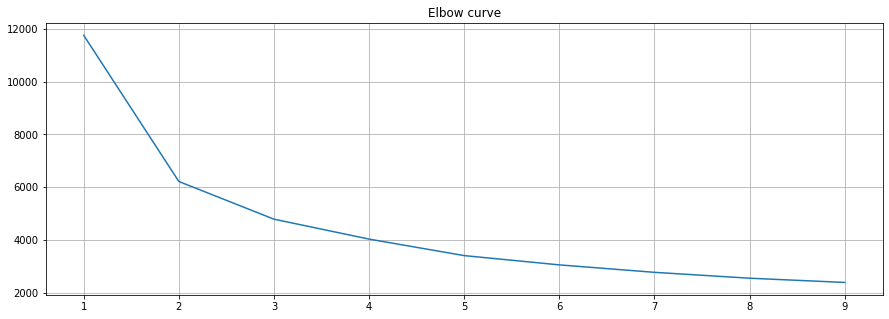

In [23]:
X = rfm_scaled.copy() # copy the normalized_df and save it to a variable named X

distorsions = [] # create an empty list named distorsions

for k in range(1, 10): # we will fit multple k-means (from k = 2 to k = 30)
    kmeans = KMeans(n_clusters=k) # creates a k-means instance
    kmeans.fit(X) # fits k-means
    distorsions.append(kmeans.inertia_) # saves the distorsions

fig = plt.figure(figsize=(15, 5)) # create a figure space with a given figure size

plt.plot(range(1, 10), distorsions) #  # plot the distorsions

plt.grid(True) # inserts grids 

plt.title('Elbow curve') # title the plot

In [24]:
model = KMeans(n_clusters = 3) # appears that 7 is the optimal number of classes

model.fit(rfm_scaled) # fits the model

labels = model.labels_ 

In [25]:
# Assign the clusters to datamart
rfm_UK['K_Cluster'] = model.labels_
rfm_UK.head()
rfm_UK['K_Cluster'].value_counts()

1    1659
0    1421
2     840
Name: K_Cluster, dtype: int64

In [26]:
rfm_UK.head()

Recency  Frequency  Monetary_value R_Quartile F_Quartile  \
CustomerID                                                             
12346           325          1        77183.60          1          1   
12747             2        103         4196.01          4          4   
12748             1       4595        33719.73          4          4   
12749             3        199         4090.88          4          4   
12820             3         59          942.34          4          3   

           M_Quartile RFM_Segment  RFM_Score RFM_Level  K_Cluster  
CustomerID                                                         
12346               4         114        6.0    Bronze          1  
12747               4         444       12.0      Gold          2  
12748               4         444       12.0      Gold          2  
12749               4         444       12.0      Gold          2  
12820               3         433       10.0    Silver          2

In [27]:
rfm_UK.groupby('K_Cluster').mean()

Recency   Frequency  Monetary_value  RFM_Score
K_Cluster                                                   
0          166.074595   14.874736      286.654751   4.482759
1           68.969259   69.471971     1190.969936   8.168174
2           11.005952  259.440476     5863.376226  11.247619

In [28]:
rfm_UK.head()

Recency  Frequency  Monetary_value R_Quartile F_Quartile  \
CustomerID                                                             
12346           325          1        77183.60          1          1   
12747             2        103         4196.01          4          4   
12748             1       4595        33719.73          4          4   
12749             3        199         4090.88          4          4   
12820             3         59          942.34          4          3   

           M_Quartile RFM_Segment  RFM_Score RFM_Level  K_Cluster  
CustomerID                                                         
12346               4         114        6.0    Bronze          1  
12747               4         444       12.0      Gold          2  
12748               4         444       12.0      Gold          2  
12749               4         444       12.0      Gold          2  
12820               3         433       10.0    Silver          2

In [29]:
model = KMeans(n_clusters = 6) # appears that 7 is the optimal number of classes

model.fit(rfm_scaled) # fits the model

labels = model.labels_ 

# Assign the clusters to datamart
rfm_UK['K_Cluster'] = model.labels_
rfm_UK.head()
rfm_UK['K_Cluster'].value_counts()

4    980
3    863
5    717
0    543
1    410
2    407
Name: K_Cluster, dtype: int64

In [30]:
rfm_UK.head()

Recency  Frequency  Monetary_value R_Quartile F_Quartile  \
CustomerID                                                             
12346           325          1        77183.60          1          1   
12747             2        103         4196.01          4          4   
12748             1       4595        33719.73          4          4   
12749             3        199         4090.88          4          4   
12820             3         59          942.34          4          3   

           M_Quartile RFM_Segment  RFM_Score RFM_Level  K_Cluster  
CustomerID                                                         
12346               4         114        6.0    Bronze          4  
12747               4         444       12.0      Gold          2  
12748               4         444       12.0      Gold          2  
12749               4         444       12.0      Gold          2  
12820               3         433       10.0    Silver          1

In [31]:
rfm_UK.groupby('K_Cluster').mean()

Recency   Frequency  Monetary_value  RFM_Score
K_Cluster                                                   
0          187.222836    6.349908      192.152302   3.675875
1            6.036585   90.609756     1339.088537  10.231707
2            9.378378  396.132678     9945.741597  11.791155
3          195.535342   31.557358      494.849156   5.324450
4           59.838776  108.900000     1916.031308   9.289796
5           33.910739   25.859135      421.679526   6.527197

In [32]:
#VISUALISATION

In [33]:
# assign cluster column 
rfm_scaled['K_Cluster'] = model.labels_
rfm_scaled['RFM_Level'] = rfm_UK.RFM_Level
rfm_scaled.reset_index(inplace = True)
rfm_scaled.head()

CustomerID   Recency  Frequency  Monetary_value  K_Cluster RFM_Level
0       12346  1.389702  -2.736532        3.777796          4    Bronze
1       12747 -2.061260   0.726940        1.442530          2      Gold
2       12748 -2.531014   3.564969        3.113785          2      Gold
3       12749 -1.786051   1.218626        1.422482          2      Gold
4       12820 -1.786051   0.310726        0.244424          1    Silver

In [34]:
# melt rfm_scaled dataframe
rfm_melt = pd.melt(frame= rfm_scaled, id_vars= ['CustomerID', 'RFM_Level', 'K_Cluster'], var_name = 'Metrics', value_name = 'Value')
rfm_melt.head()

CustomerID RFM_Level  K_Cluster  Metrics     Value
0       12346    Bronze          4  Recency  1.389702
1       12747      Gold          2  Recency -2.061260
2       12748      Gold          2  Recency -2.531014
3       12749      Gold          2  Recency -1.786051
4       12820    Silver          1  Recency -1.786051

In [35]:
rfm_melt.head()

CustomerID RFM_Level  K_Cluster  Metrics     Value
0       12346    Bronze          4  Recency  1.389702
1       12747      Gold          2  Recency -2.061260
2       12748      Gold          2  Recency -2.531014
3       12749      Gold          2  Recency -1.786051
4       12820    Silver          1  Recency -1.786051

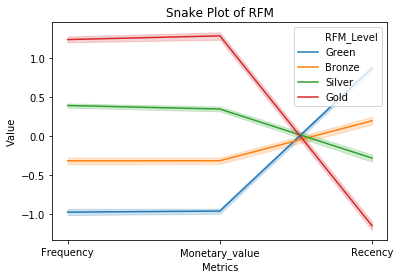

In [36]:
# a snake plot with RFM
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melt)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

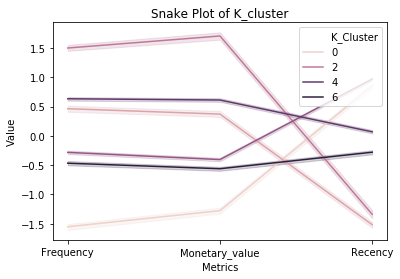

In [37]:
# a snake plot with K-Means
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melt)
plt.title('Snake Plot of K_cluster')
plt.legend(loc = 'upper right')

In [38]:
#HeatMap

In [39]:
# the mean value for each cluster
levelcluster_avg = rfm_UK.groupby('RFM_Level').mean().iloc[:, 0:3]
levelcluster_avg.head()

Recency   Frequency  Monetary_value
RFM_Level                                        
Green      190.099574   14.945532      259.412137
Bronze      87.727050   33.280294      783.119010
Silver      46.758944   82.034923     1531.314584
Gold        12.893899  282.839523     6055.717162

In [40]:
# the mean value in total 
total_avg = rfm_UK.iloc[:, 0:3].mean()
total_avg

Recency             91.749235
Frequency           90.388010
Monetary_value    1864.385601
dtype: float64

In [41]:
prop_rfm = levelcluster_avg/total_avg - 1
prop_rfm

Recency  Frequency  Monetary_value
RFM_Level                                     
Green      1.071947  -0.834651       -0.860859
Bronze    -0.043839  -0.631806       -0.579959
Silver    -0.490361  -0.092414       -0.178649
Gold      -0.859466   2.129171        2.248103

[]

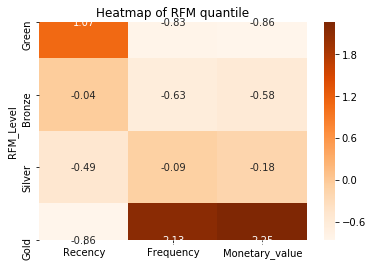

In [42]:
# heatmap
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True)
plt.title('Heatmap of RFM quantile')
plt.plot()

In [43]:
# the mean value for each cluster
Kcluster_avg = rfm_UK.groupby('K_Cluster').mean().iloc[:, 0:3]

# the proportional mean value
prop_rfm_K = Kcluster_avg/total_avg - 1
prop_rfm_K

Recency  Frequency  Monetary_value
K_Cluster                                     
0          1.040593  -0.929748       -0.896935
1         -0.934206   0.002453       -0.281753
2         -0.897782   3.382580        4.334595
3          1.131193  -0.650868       -0.734578
4         -0.347801   0.204806        0.027701
5         -0.630398  -0.713910       -0.773824

[]

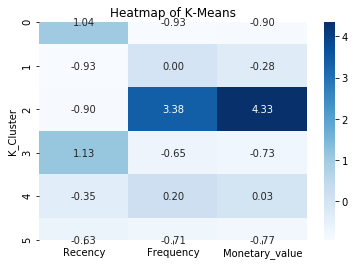

In [44]:
sns.heatmap(prop_rfm_K, cmap= 'Blues', fmt= '.2f', annot = True)
plt.title('Heatmap of K-Means')
plt.plot()